In [1]:
# import
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
from PIL import Image
import shutil
from glob import iglob

# costants
SEED = 0xDED

target_w = 512
target_h = 512


num_classes = 3    

In [2]:
# usefull functions
# Print iterations progress
def printProgressBar (iteration, total, prefix = 'Progress', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

def fromCwd(path):
    return os.path.join(os.getcwd(), path)


In [3]:
# intialization and common utilities

tf.random.set_seed(SEED)
np.random.seed(SEED)

data_dir = "/kaggle/input/contadinoset/Development_Dataset/Training"
temp_dir = "/kaggle/temp/mvdir"
checkpoint_dir = "/kaggle/temp/checkpoints"
test_dir = "/kaggle/input/contadinoset/Development_Dataset/Test_Dev"
output_dir = "/kaggle/working"


In [4]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("RIP no gpu")

Default GPU Device:/device:GPU:0


In [5]:

#convert a mask in rgb to actual classes
def rgb_to_class(mask_arr):
    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr  
    
    
def process_image(pil_img):
    img = pil_img.resize([target_w, target_h])
    img = np.array(img) / 255.

    return img


def process_mask(pil_img):
    mask = pil_img.resize([target_w, target_h], resample=Image.NEAREST)
    mask = np.array(mask)
    mask = rgb_to_class(mask)
    mask = np.expand_dims(mask, -1)

    return mask


def shuffle(images, masks):
    
    
    for i in range(len(images)):
        idx = np.random.randint(0, len(images))
        # swap an keep track of old place
        temp_i = images[idx]
        temp_m = masks[idx]
        
        images[idx] = images[i]
        masks[idx] = masks[i]
        
        images[i] = temp_i
        masks[i] = temp_m

# move all data to images or mask folders into dest dir
def loadAllData(source_dir, valid_percent):
    x_train = []
    y_train = []
    x_valid = []
    y_valid = []

    for folder in iglob(source_dir+'/*/*'):

        # here we got Images in subfolder
        im_dir = os.path.join(folder, "Images")
        ms_dir = os.path.join(folder, "Masks")
        # read all images and masks
        images = np.sort(os.listdir(im_dir))
        masks = np.sort(os.listdir(ms_dir))

        # make validation
        val_sz = int(len(images) * valid_percent) + 1
        for i in range(val_sz):
            idx = np.random.randint(0, len(images))

            if os.path.splitext(images[idx])[0] != os.path.splitext(masks[idx])[0]:
                print("Image-Mask mismatch for: " +images[idx]+" -> "+ masks[idx])

            x_valid.append(process_image(Image.open(os.path.join(im_dir, images[idx]))))
            y_valid.append(process_mask(Image.open(os.path.join(ms_dir, masks[idx]))))

            sp = folder.split("/")
            printProgressBar(i+1, val_sz, prefix=str(i+1)+"/"+str(val_sz), suffix="Valid: "+sp[-2]+" - "+ sp[-1])

            # update refreshed folders without moved elements
            images = np.delete(images, idx)
            masks = np.delete(masks, idx)
        
        # train data
        for idx in range(len(images)):
            if os.path.splitext(images[idx])[0] != os.path.splitext(masks[idx])[0]:
                print("Image-Mask mismatch for: " +self.images[index]+" -> "+ self.masks[index])

            x_train.append(process_image(Image.open(os.path.join(im_dir, images[idx]))))
            y_train.append(process_mask(Image.open(os.path.join(ms_dir, masks[idx]))))

            sp = folder.split("/")
            printProgressBar(idx+1, len(images), prefix=str(idx+1)+"/"+str(len(images)), suffix="Train: " + sp[-2]+" - "+ sp[-1])

    return np.array(x_train), np.array(y_train), np.array(x_valid), np.array(y_valid)

#end    


x_train, y_train, x_valid, y_valid = loadAllData(data_dir, 0.1)

#shuffle(x_train, y_train)
#shuffle(x_valid, y_valid)

print("Train images: "+ str(len(x_train)))
print("Validation images: "+ str(len(x_valid)))

10/10 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Valid: Pead - Mais
80/80 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Train: Pead - Mais
10/10 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Valid: Pead - Haricot
80/80 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Train: Pead - Haricot
10/10 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Valid: Roseau - Mais
80/80 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Train: Roseau - Mais
10/10 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Valid: Roseau - Haricot
80/80 |█████████████████████████████████

[0 1 2]


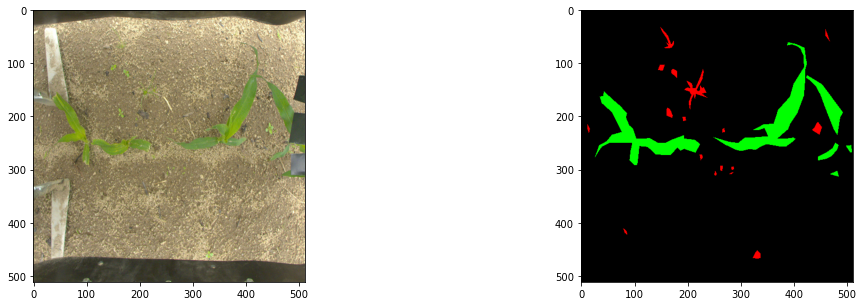

[0 1 2]


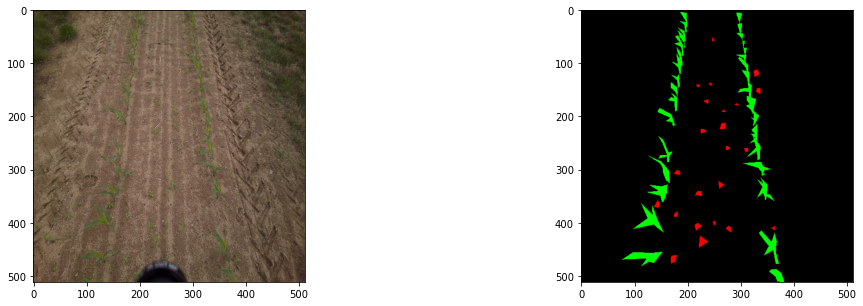

In [6]:
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

for k in range(2):
  # plot
  fig, ax = plt.subplots(1, 2)
  fig.set_size_inches(18, 5, forward=True)
  
  idx = np.random.randint(0, len(x_train))
  augmented_img = x_train[idx]
  target = y_train[idx]

  augmented_img = augmented_img * 255  # denormalize

  target_img = np.zeros([target.shape[0], target.shape[1], 3])
  target = tf.squeeze(target, axis=-1)
  #target = np.array(target).flatten()

  print(np.unique(target))


  target_img[np.where(target == 0)] = [0, 0, 0]
  target_img[np.where(target == 1)] = [0, 255, 0] 
  target_img[np.where(target == 2)] = [255, 0, 0] 

  ax[0].imshow(np.uint8(augmented_img))
  ax[1].imshow(np.uint8(target_img))

  plt.show()

In [7]:

vgg = keras.applications.VGG16(input_shape=[target_h, target_w, 3], include_top=False)
for l in vgg.layers[:int(len(vgg.layers) * 0.2)]:
    l.trainable = False

vgg.summary()

def up_block(down_in, prev, z_sz):
    prev = keras.layers.UpSampling2D()(prev)
    prev = keras.layers.Concatenate(axis=-1)([down_in, prev])
    prev = keras.layers.Conv2D(z_sz,3, activation = 'relu', padding = 'same')(prev)
    return keras.layers.Conv2D(z_sz,3, activation = 'relu', padding = 'same')(prev)

mult = 1

last = up_block(vgg.layers[-6].output, vgg.layers[-2].output, 256 * mult)
last = up_block(vgg.layers[-10].output, last, 128 * mult)
last = up_block(vgg.layers[-14].output, last, 64 * mult)
last = up_block(vgg.layers[-17].output, last, 32 * mult)

last = keras.layers.Conv2D(16 * mult, 3, activation = 'relu', padding = 'same')(last)
last = keras.layers.Conv2D(16 * mult, 3, activation = 'relu', padding = 'same')(last)

last = keras.layers.Conv2D(num_classes, 1, activation = 'softmax')(last)

model = keras.Model(vgg.input, last)
model.summary()


58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
______________________________________________________________

In [8]:
import tensorflow.keras.backend as K

learning_rate = 1e-5

def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first


        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(np.int64(i), classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc


def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)


# compole model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=weightedLoss(keras.losses.SparseCategoricalCrossentropy(),[1,1,5]), 
    metrics=[meanIoU] 
    )

In [9]:
from datetime import datetime

now = datetime.now().strftime('%b%d_%H-%M-%S')

#checkpoint_dir = checkpoint_dir+str(now)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# setup callbacks
# -----------------------

class ShuffleCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        shuffle(x_train, y_train)




callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'cp_{epoch:02d}.ckpt'), save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
    #ShuffleCallback()
]


In [10]:
batch_size = 1
epochs = 30

history = model.fit(
          x=x_train,
          y=y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks
          )

Epoch 1/30
640/640 [==============================] - 64s 100ms/step - loss: 0.1590 - meanIoU: 0.2377 - val_loss: 0.1016 - val_meanIoU: 0.3729
Epoch 2/30
640/640 [==============================] - 63s 98ms/step - loss: 0.0931 - meanIoU: 0.4363 - val_loss: 0.0809 - val_meanIoU: 0.4782
Epoch 3/30
640/640 [==============================] - 62s 97ms/step - loss: 0.0801 - meanIoU: 0.4980 - val_loss: 0.0746 - val_meanIoU: 0.5245
Epoch 4/30
640/640 [==============================] - 63s 99ms/step - loss: 0.0732 - meanIoU: 0.5335 - val_loss: 0.0708 - val_meanIoU: 0.5353
Epoch 5/30
640/640 [==============================] - 63s 98ms/step - loss: 0.0690 - meanIoU: 0.5654 - val_loss: 0.0691 - val_meanIoU: 0.5539
Epoch 6/30
640/640 [==============================] - 64s 100ms/step - loss: 0.0663 - meanIoU: 0.5818 - val_loss: 0.0664 - val_meanIoU: 0.5759
Epoch 7/30
640/640 [==============================] - 58s 91ms/step - loss: 0.0633 - meanIoU: 0.6020 - val_loss: 0.0703 - val_meanIoU: 0.5559
Epoc

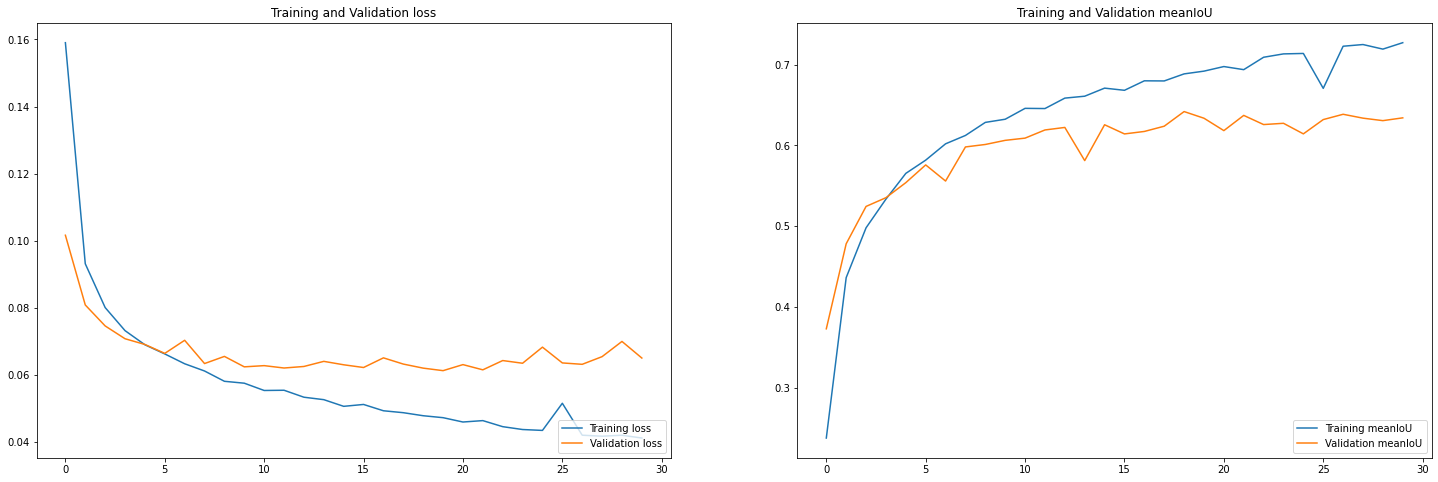

In [11]:
# plot alla metrics 
idx = 1
mtr = ['loss','meanIoU']

plt.figure(figsize=(25, 8))

for m in mtr:
    x = history.history[m]
    val_x = history.history['val_' + m]

    plt.subplot(1, len(mtr), idx)
    plt.plot(x, label='Training ' + m)
    plt.plot(val_x, label='Validation ' + m)
    plt.legend(loc='lower right')
    plt.title('Training and Validation ' + m)
    idx += 1

plt.show()

In [12]:
def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# return {rle crop prediction, rle weed prediction} img shape
def make_prediction(model, image):

    #print("Original size: "+ str(image.size))

    img = image.resize([target_w, target_h]) # resize to the network expected size and keep a copy of the original img
    img = np.array(img) / 255. # rescale
    img = tf.expand_dims(img, 0) # add "batch" dimension

    out = model(img, training=False) # predict

    out= tf.squeeze(out, 0) # remove batch dimension to get a 3d vector
    # we got a 3d vector with 3 deph and we need to rescale it to original input size
    # so we denormalize if (output of softmax is 0 < val < 1)
    # and we treat it as img to resize in plt
    out = Image.fromarray(np.uint8(out * 255.)).resize(image.size)
    #print("Predictions:" + str(out.size))
    out = np.array(out)
    # rescale and resize should preserve the old max channels
    # so we can ignore the rescaling to 0-1 again
    out = tf.math.argmax(out, axis=-1) 

    

    return out, image.size

# create function to evaluate the model and output results in requeisted format
def output_predictions(model, test_dir):
    submission_dict = {}
    #print(test_dir)

    # iterate all datasets keeping name
    for team in os.listdir(test_dir): #team == dataset name
        team_dir = os.path.join(test_dir, team)

        # iterate all corps for a dataset keeping name
        for crop in os.listdir(team_dir):
            crop_dict = {}
            img_dir = os.path.join(team_dir, crop)
            img_dir = os.path.join(img_dir, "Images")
            # iterate all images 
            files = os.listdir(img_dir)
            i = 0
            for fl in files:
                #print("img: "+ fl)
                # get prediction from model
                image = Image.open(os.path.join(img_dir, fl))
                prediction, shape = make_prediction(model, image)
                
                prediction = np.array(prediction)

                filename, file_extension = os.path.splitext(fl)
                # prepare output dict
                submission_dict[filename] = {
                    'shape': shape,
                    'team': team,
                    'crop': crop,
                    'segmentation': {'crop': rle_encode(prediction == 1), 'weed':rle_encode(prediction == 2)}
                }

                i += 1
                printProgressBar(i, len(files), prefix="Prediction", suffix=team+" - "+crop)
            # end for fl
        # end for crop
    #end for team

    return submission_dict
    


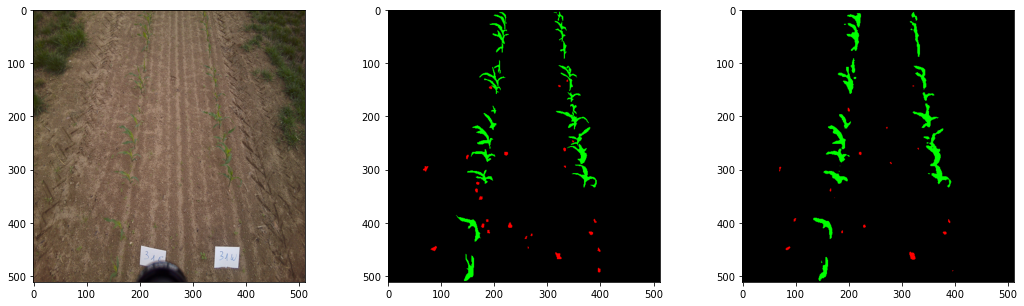

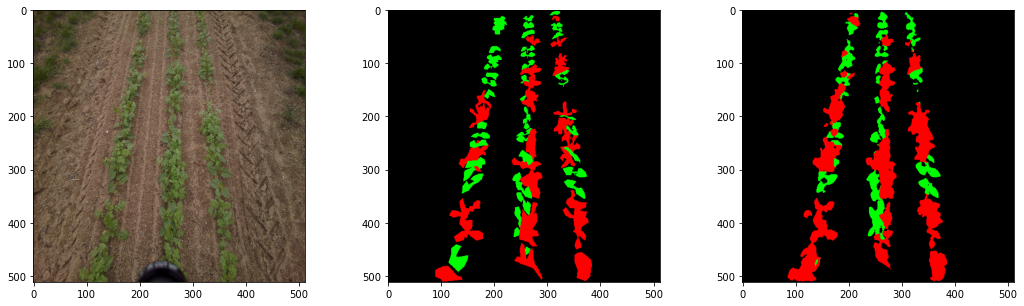

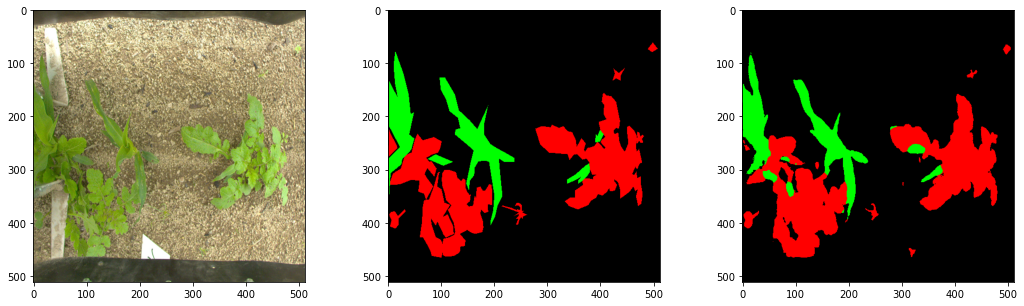

In [13]:
# plot result of a validation image to understand if net is learning right
samples = 3

for i in range(samples):
    idx = np.random.randint(0, len(x_valid))
    img = x_valid[idx]
    mask = y_valid[idx]

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(18, 5, forward=True)

    img = np.array(img) * 255
    i = Image.fromarray(np.uint8(img))
    out, shape = make_prediction(model, i)

    # expected mask

    target_img = np.zeros([target.shape[0], target.shape[1], 3])
    target = tf.squeeze(mask, axis=-1)

    target_img[np.where(target == 0)] = [0, 0, 0]
    target_img[np.where(target == 1)] = [0, 255, 0] 
    target_img[np.where(target == 2)] = [255, 0, 0] 

    #prediction
    out_img = np.zeros([out.shape[0], out.shape[1], 3])

    out_img[np.where(out == 0)] = [0, 0, 0]
    out_img[np.where(out == 1)] = [0, 255, 0] 
    out_img[np.where(out == 2)] = [255, 0, 0] 

    ax[0].imshow(np.uint8(img))
    ax[1].imshow(np.uint8(target_img))
    ax[2].imshow(np.uint8(out_img))

    plt.show()


In [14]:
import json

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# output last model
print("Making prediction with latest model...")
loss, metrics = model.evaluate(x=x_valid, y=y_valid, verbose=2, steps=len(x_valid))

iou = "{:5.2f}".format(100 * metrics)
loss = "{:5.2f}".format(loss)

print("Last model expected results: loss:{}, iou: {}%".format(loss, iou))
res = output_predictions(model, test_dir)

name = '0latest_iou' + iou + '_loss' + loss +'.json'
with open(os.path.join(output_dir, name), 'w') as fp:
        json.dump(res, fp)

print("Done")

Making prediction with latest model...
80/80 - 3s - loss: 0.0650 - meanIoU: 0.6342
Last model expected results: loss: 0.07, iou: 63.42%
Prediction |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Pead - Mais
Prediction |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Pead - Haricot
Prediction |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Roseau - Mais
Prediction |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Roseau - Haricot
Prediction |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Weedelec - Mais
Prediction |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Weedelec - Haricot
Prediction |█████████████████████████████████

In [15]:
! ls /kaggle/temp/checkpoints

cp_01.ckpt  cp_03.ckpt	cp_05.ckpt  cp_08.ckpt	cp_12.ckpt  cp_20.ckpt
cp_02.ckpt  cp_04.ckpt	cp_06.ckpt  cp_10.ckpt	cp_19.ckpt


In [18]:
import json

# predict with checkpoint models
print("Making prediction with best models, this may take a while...")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

num = 0
ckps = os.listdir(checkpoint_dir)
ckps = ['cp_20.ckpt']

for cp in ckps:
    path_to_model = os.path.join(checkpoint_dir, cp)
    m2 = tf.keras.models.load_model(path_to_model, custom_objects={'meanIoU':meanIoU})
    

    loss, metrics = m2.evaluate(x=x_valid, y=y_valid, verbose=2, steps=len(x_valid))

    #acc = "{:5.2f}".format(100 * metrics)
    iou = "{:5.2f}".format(100 * metrics)
    loss = "{:5.2f}".format(loss)

    print("Model expected results: loss:{}, iou: {}%".format(loss, iou))
    res = output_predictions(model, test_dir)

    # write to file
   
    name = 'iou' + iou + '_loss' + loss +'.json'
    with open(os.path.join(output_dir, name), 'w') as fp:
        json.dump(res, fp)

    num += 1
    print("Progress: "+str(num)+"/"+str(len(ckps)))

print("Done")

Making prediction with best models, this may take a while...


ValueError: Unknown loss function: lossFunc